## A.1 Import libraries

In [41]:
#Libraries you have
library(ggplot2)
library(dplyr)

In [2]:
#Libraries to install
#library(lmtest) # Regression diagnostics
#library(MASS) #Robust regressions
#library(plm) #Fixed and Random effects regression

## A.2 Import data

In [3]:
mtcars = as_tibble(mtcars)
#rownames(mtcars) <- NULL
mtcars %>% head(2)

mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
21,6,160,110,3.9,2.620,16.46,0,1,4,4
21,6,160,110,3.9,2.875,17.02,0,1,4,4


# 1. OLS regression

## 1.1 OLS: Built-in package lm
- lm(Y~ X, data=DATAFRAME)

### 1.1.1 Regression summary

In [4]:
linear_reg = lm(mpg ~ wt, data=mtcars)
print(summary(linear_reg))


Call:
lm(formula = mpg ~ wt, data = mtcars)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.5432 -2.3647 -0.1252  1.4096  6.8727 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  37.2851     1.8776  19.858  < 2e-16 ***
wt           -5.3445     0.5591  -9.559 1.29e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.046 on 30 degrees of freedom
Multiple R-squared:  0.7528,	Adjusted R-squared:  0.7446 
F-statistic: 91.38 on 1 and 30 DF,  p-value: 1.294e-10



#### 1.1.1.1 Acessing coefficients from summary

In [5]:
linear_reg_summary = summary(linear_reg )
linear_reg_summary$coefficients
linear_reg_summary$fstatistic
linear_reg_summary$sigma
linear_reg_summary$r.squared

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),37.285126,1.877627,19.857575,8.241799e-19
wt,-5.344472,0.559101,-9.559044,1.293959e-10


value    numdf    dendf 
91.37533  1.00000 30.00000

[1] 3.045882

[1] 0.7528328

#### 1.1.1.2 Extracting other stats from regression

In [6]:
deviance(linear_reg)# SSR
logLik(linear_reg) #Log likelihood
linear_reg$df #Degrees of freedom
#linear_reg$fitted.values #Yhat
#linear_reg$coefficients #coefficients
#linear_reg$residuals #Residuals
AIC(linear_reg) #AIC

[1] 278.3219

'log Lik.' -80.01471 (df=3)

[1] 30

[1] 166.0294

#### 1.1.1.2 Acessing only Estimates ($\beta$), Std. error, t-values

In [7]:
#linear_reg_summary$coefficients["wt","Std. Error"] #Std. errors
#linear_reg_summary$coefficients["wt","t value"] #T-value
beta1_lm = linear_reg_summary$coefficients["wt","Estimate"] #Beta 
beta1_lm

[1] -5.344472

### 1.1.2 Regression residuals

In [8]:
resids = as.vector(linear_reg$residuals) #Yhat list of predicted values

In [9]:
reg_df = mtcars  %>% select(wt, mpg) #Create new df
reg_df = reg_df %>% mutate(yhat = resids) #Add yhat residuals we just created as a new column

#### 1.1.2.1 Plot regression residuals
- This is an important step to recognize heteroskedasticity

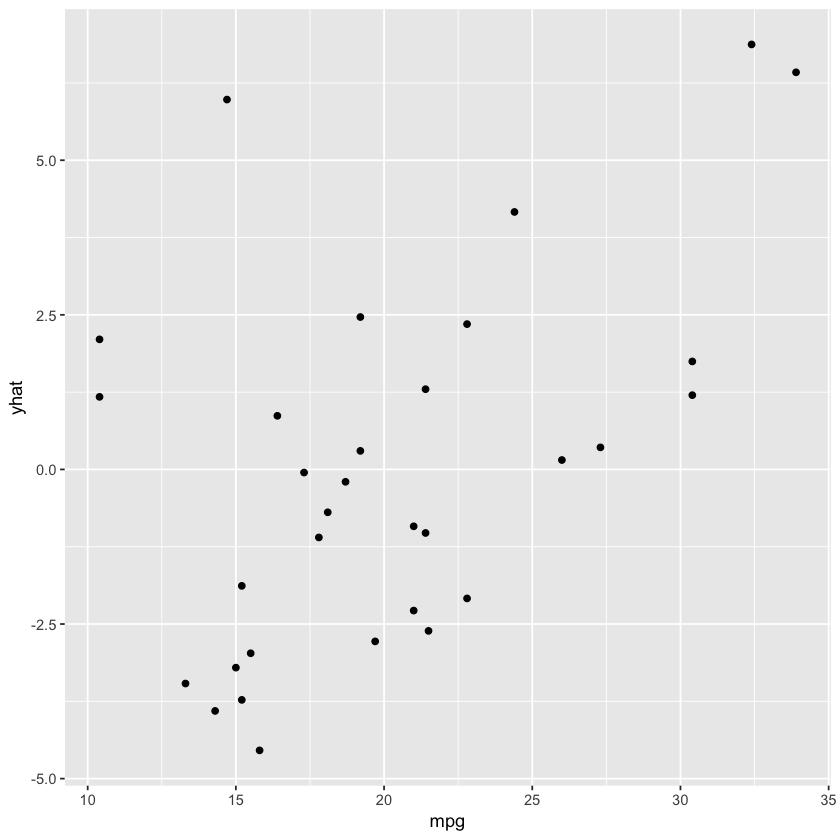

In [10]:
reg_df %>% ggplot(aes(mpg, yhat))+ geom_point()

## 1.2 OLS: Using matrix algebra


### 1.2.1 Create matrices for X and Y values

In [11]:
X = as.matrix(mtcars %>% select(wt)) 
X = cbind(X,rep(1,length(X))) #Add constant/intercept
colnames(X)[2] <- "Intercept" #Name intercept
Y = as.matrix(mtcars %>% select(mpg))

### 1.2.2 Calculate $\beta$

$y= x\hat\beta \Rightarrow \hat\beta = (x\prime x)^{-1}x\prime y$


Matrix algebra notes:
- t() = transpose
- %*% = dot product
- solve() = inverse

In [12]:
A = solve(t(X)%*%X)
bhat_hand = A  %*% t(X) %*% Y 
print(bhat_hand)

                mpg
wt        -5.344472
Intercept 37.285126


#### 1.2.2.1 Show lm-beta == hand calculated-beta 
- (1.1.1.2==1.1.2)

In [13]:
linear_reg_summary$coefficients[,"Estimate"] 

(Intercept)          wt 
  37.285126   -5.344472

In [14]:
#Just to make sure our eyes are not tricking us, check to see whether wt coefficients are equal 
beta1_hand = bhat_hand[1]
paste("Beta_1 by hand:", round(beta1_hand,2))
paste("Beta_1 by lm package:", round(beta1_lm,2))
paste("Is Beta_1 from lm and by hand equal?", round(beta1_lm,2) == round(beta1_hand,2))

[1] "Beta_1 by hand: -5.34"

[1] "Beta_1 by lm package: -5.34"

[1] "Is Beta_1 from lm and by hand equal? TRUE"

### 1.2.3 Calculate $\hat{e}$
$\hat{e} = Y - X' \hat{\beta}$. 

In [15]:
residuals_hand = Y - (X %*% bhat_hand)
#ehat

### 1.2.4 Calculate standard error
- Example derived from Rebecca Ferrel's [github](http://rebeccaferrell.github.io/CSSS508/Homework/template-HW4-key.html)

#### 1.2.4.1 Residual variance


In [16]:
p <- ncol(X) - 1
residual_var <- t(residuals_hand) %*% residuals_hand / (n - p - 1)
residual_var <- as.numeric(residual_var)

#### 1.2.4.2 $Var(\hat{\beta})$

In [17]:
beta_covar_hand <- residual_var * A
beta_covar_hand

,wt,Intercept
wt,0.312594,-1.005693
Intercept,-1.005693,3.525484


#### 1.2.4.3 Standard error: $\sqrt{var(\hat{\beta})}$

In [18]:
beta_SE_hand <- sqrt(diag(beta_covar_hand))
beta_SE_hand

wt Intercept 
 0.559101  1.877627

#### 1.2.4.4 Show lm-se == hand calculated-se 
- (1.2.4.3==1.1.1.1)

In [19]:
#Code from 1.1.1.2
beta1_se_lm = linear_reg_summary$coefficients['wt',"Std. Error"] #Grab only wt se
linear_reg_summary$coefficients[,"Std. Error"] 

(Intercept)          wt 
   1.877627    0.559101

In [20]:
#Just to make sure our eyes are not tricking us, check to see whether wt coefficients are equal 
beta1_SE_hand = beta_SE_hand[1]
paste("beta1 SE by hand:", round(beta1_SE_hand,2))
paste("SE by lm package:", round(beta1_se_lm ,2))
paste("Is Beta_1 SE from lm and by hand equal?", round(beta1_SE_hand,2) ==  round(beta1_se_lm ,2))

[1] "beta1 SE by hand: 0.56"

[1] "SE by lm package: 0.56"

[1] "Is Beta_1 SE from lm and by hand equal? TRUE"

# 2. Regression diagnostics

- [lmtest package](http://math.furman.edu/~dcs/courses/math47/R/library/lmtest/html/00Index.html)

In [42]:
library(lmtest)

## 2.1 Breusch pagan: test for heteroskedasticity

- If any of $\delta$ are different than zero other than $\delta_0$ then there is heteroscedasticity


In [22]:
linear_reg = lm(mpg ~ wt, data=mtcars)
bptest(linear_reg)


	studentized Breusch-Pagan test

data:  linear_reg
BP = 0.040438, df = 1, p-value = 0.8406


In [23]:
diagnostics <- function(regression) {
    bp_res = bptest(linear_reg)$p.value
    if (bp_res<.1){
        print(paste("P-value", round(bp_res,3)))
        print("Reject null. Thus there is evidence of heteroskedasticity")
    }
    else{
        print(paste("P-value", round(bp_res,3)))
        print("Cannot reject null. No evidence of heteroskedasticity")
    } 
}

In [24]:
diagnostics(linear_reg)

[1] "P-value 0.841"
[1] "Cannot reject null. No evidence of heteroskedasticity"


## 2.2  DW test: test for serial correlation

Serial correlation occurs when:
- Important variable is omitted
- Functional misspecification
- Measurement error in independent variable

This statistic will always be between 0 and 4.
- Inidication of no serial correlation: the test statistic equals 2.
- The closer to 0 the statistic, the more evidence for positive serial correlation.
- The closer to 4, the more evidence for negative serial correlation.

In [25]:
dwtest(linear_reg)


	Durbin-Watson test

data:  linear_reg
DW = 1.2517, p-value = 0.0102
alternative hypothesis: true autocorrelation is greater than 0


## 2.3 Functional misspecification

- If our model is correctly specified T-test of $\gamma_1$ should not be rejected
- If we reject the null then there is functional misspecfication

In [26]:
resettest(linear_reg)


	RESET test

data:  linear_reg
RESET = 5.1315, df1 = 2, df2 = 28, p-value = 0.01263


## 2.4 Introduction to functions

### 2.4.1 Function: square numbers

In [27]:
square = function(a){
    solution = a^2
    return (solution)
}

In [28]:
square(4)

[1] 16

### 2.4.2 Function: add two numbers

In [29]:
add_numbers = function(a,b){
    solution = (a^2)+b
    return (solution)
}

In [30]:
add_numbers(2,3)

[1] 7

### 2.4.3 Function: using if and else

In [31]:
number_test = function(a,b,c) { 
    print('You can print anything you want inside functions')
    solution1 = a+b
    solution = solution1-c
    print(paste("The solution is:", solution))
    if (solution>100){
        print('Big numbers are lame')
    }
    else{
        print('Small numbers are cool')
    }
}

In [32]:
number_test(1,2,5)

[1] "You can print anything you want inside functions"
[1] "The solution is: -2"
[1] "Small numbers are cool"


### 2.4.4 Function: BP, DW and RESET Test 

In [33]:
diagnostics = function(regression) { 
    #BP-test
    print('-------')
    print('BP-Test')
    bp_res = bptest(linear_reg)$p.value
    if (bp_res<.1){
        print(paste("P-value", round(bp_res,3)))
        print("Reject null. Thus there is evidence of heteroskedasticity")
    }
    else{
        print(paste("P-value", round(bp_res,3)))
        print("Cannot reject null. No evidence of heteroskedasticity")
    }
    #DW-test
    print('-------')
    print('DW-Test')
    dw_res = dwtest(linear_reg)$p.value
    if (dw_res<.1){
        print(paste("P-value", round(dw_res,3)))
        print("Reject null. Thus there is evidence of serial correlation")
    }
    else{
        print(paste("P-value", round(bp_res,3)))
        print("Cannot reject null. No evidence of serial correlation")
    } 
    #Ramsey Reset test
    print('-------')
    print('Rest-Test')
    ram_res = resettest(linear_reg)$p.value
    if (ram_res<.1){
        print(paste("P-value", round(ram_res,3)))
        print("Reject null. Thus there is evidence of misspecification")
    }
    else{
        print(paste("P-value", round(ram_res,3)))
        print("Cannot reject null. No evidence of  misspecification")
    } 
}

In [34]:
diagnostics(linear_reg)

[1] "-------"
[1] "BP-Test"
[1] "P-value 0.841"
[1] "Cannot reject null. No evidence of heteroskedasticity"
[1] "-------"
[1] "DW-Test"
[1] "P-value 0.01"
[1] "Reject null. Thus there is evidence of serial correlation"
[1] "-------"
[1] "Rest-Test"
[1] "P-value 0.013"
[1] "Reject null. Thus there is evidence of misspecification"


## 3. Other regression models

## 3.1 Robust S.E. regression

In [43]:
library(MASS)

In [36]:
rlm(mpg ~ wt, mtcars)

Call:
rlm(formula = mpg ~ wt, data = mtcars)
Converged in 5 iterations

Coefficients:
(Intercept)          wt 
  36.737870   -5.250336 

Degrees of freedom: 32 total; 30 residual
Scale estimate: 3.06 

## 3.2 Panel data estimators
- [plm package](https://cran.r-project.org/web/packages/plm/plm.pdf)

In [44]:
library(plm)

In [38]:
data("Grunfeld", package="plm")
Grunfeld  %>% head(3)

firm,year,inv,value,capital
1,1935,317.6,3078.5,2.8
1,1936,391.8,4661.7,52.6
1,1937,410.6,5387.1,156.9


### 3.2.1 Fixed effects

In [39]:
grun.fe <- plm(inv~value+capital, data = Grunfeld, model = "within")
summary(grun.fe)

Oneway (individual) effect Within Model

Call:
plm(formula = inv ~ value + capital, data = Grunfeld, model = "within")

Balanced Panel: n = 10, T = 20, N = 200

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-184.00857  -17.64316    0.56337   19.19222  250.70974 

Coefficients:
        Estimate Std. Error t-value  Pr(>|t|)    
value   0.110124   0.011857  9.2879 < 2.2e-16 ***
capital 0.310065   0.017355 17.8666 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    2244400
Residual Sum of Squares: 523480
R-Squared:      0.76676
Adj. R-Squared: 0.75311
F-statistic: 309.014 on 2 and 188 DF, p-value: < 2.22e-16

### 3.2.2 Random effects

In [40]:
grun.re <- plm(inv~value+capital, data = Grunfeld, model = "random")
summary(grun.re)

Oneway (individual) effect Random Effect Model 
   (Swamy-Arora's transformation)

Call:
plm(formula = inv ~ value + capital, data = Grunfeld, model = "random")

Balanced Panel: n = 10, T = 20, N = 200

Effects:
                  var std.dev share
idiosyncratic 2784.46   52.77 0.282
individual    7089.80   84.20 0.718
theta: 0.8612

Residuals:
     Min.   1st Qu.    Median   3rd Qu.      Max. 
-177.6063  -19.7350    4.6851   19.5105  252.8743 

Coefficients:
              Estimate Std. Error z-value Pr(>|z|)    
(Intercept) -57.834415  28.898935 -2.0013  0.04536 *  
value         0.109781   0.010493 10.4627  < 2e-16 ***
capital       0.308113   0.017180 17.9339  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    2381400
Residual Sum of Squares: 548900
R-Squared:      0.7695
Adj. R-Squared: 0.76716
Chisq: 657.674 on 2 DF, p-value: < 2.22e-16